# 기본적인 EDA

In [51]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-3rd-edition/'
                 'master/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
              'NOX', 'RM', 'AGE', 'DIS', 'RAD',
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


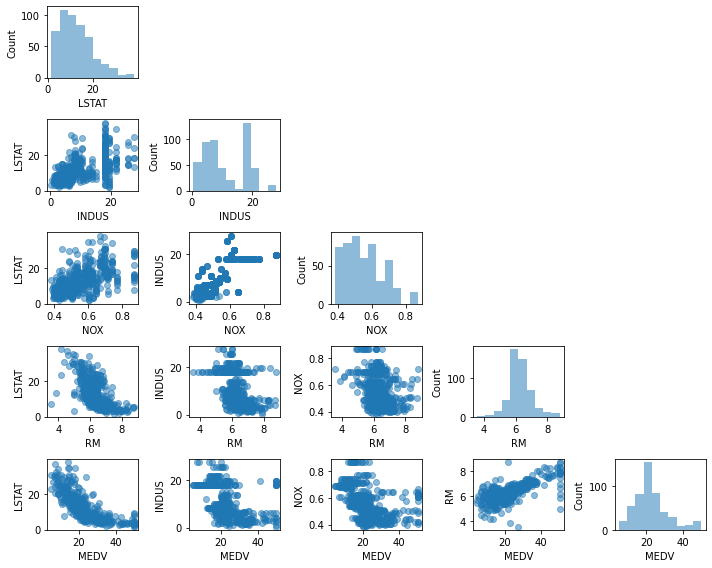

In [52]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values, figsize=(10, 8), names=cols, alpha=0.5)
plt.tight_layout()
plt.show()

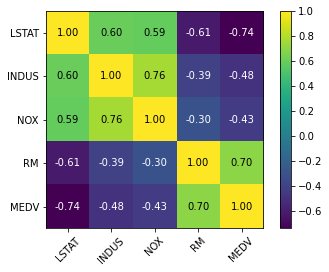

In [53]:
from mlxtend.plotting import heatmap
import numpy as np
cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

plt.show()

scatterplot과 heatmap을 고려하면, RM 변수가 선형성을 가지고 있으므로, 선형회귀 모델을 만들기에 적합함을 알 수 있다.

# 경사하강법을 이용한 선형회귀

In [54]:
class LinearRegressionGD(object):
    def __init__(self, eta = 0.001, n_iter = 20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)

        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [55]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() # 1차원 배열형태로 바꿔줌

In [56]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

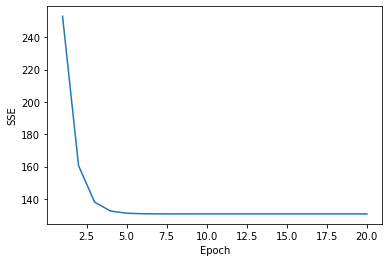

In [57]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [58]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolors='white', s = 70)
    plt.plot(X, model.predict(X), color='black', lw=2)
    return None

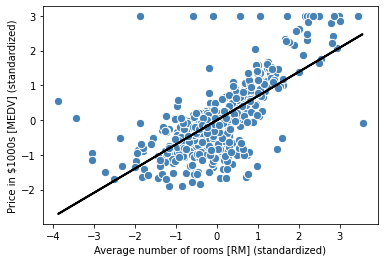

In [59]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

In [60]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print('Price in $1000s: %.3f' % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


In [61]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


# 사이킷런을 통한 선형회귀 구축

In [62]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


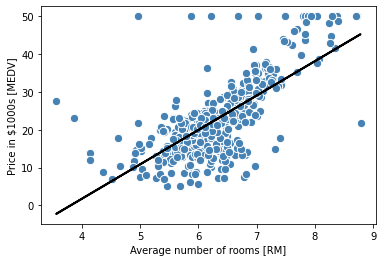

In [63]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

# Robust regression using RANSAC

In [64]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=50,
                         loss = 'absolute_loss', residual_threshold=5.0, random_state=0)

ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(), min_samples=50,
                random_state=0, residual_threshold=5.0)

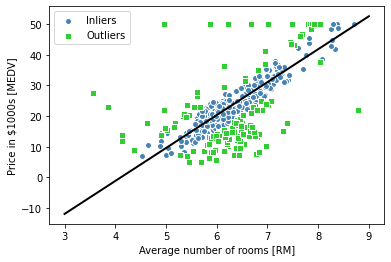

In [65]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c = 'steelblue', edgecolors='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='limegreen', edgecolors='white', marker='s', label = 'Outliers')
plt.plot(line_X, line_y_ransac, color = 'black', lw=2)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [66]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


# 회귀모델 평가

In [67]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

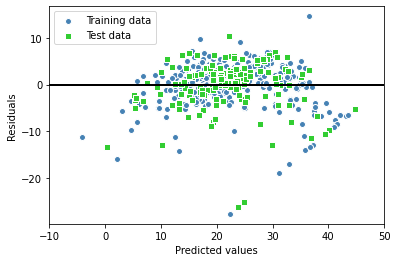

In [68]:
plt.scatter(y_train_pred, y_train_pred - y_train, c = 'steelblue', marker='o', edgecolors='white', label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolors='white', label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [70]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' %
      (r2_score(y_train, y_train_pred),
       (r2_score(y_test, y_test_pred))))

R^2 train: 0.765, test: 0.673


# Regularizing to tackling the problem of overfitting

In [71]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

In [72]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

In [73]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Polynomial regression

In [74]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
# 즉 2차고, 어느 값이 3일때 위의 메서드를 적용하면 3,9로 변환시켜줌
X_quad= quadratic.fit_transform(X)

In [75]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [76]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

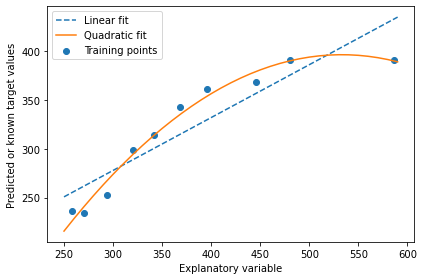

In [77]:
plt.scatter(X, y, label = 'Training points')
plt.plot(X_fit, y_lin_fit, label = 'Linear fit', linestyle = '--')
plt.plot(X_fit, y_quad_fit, label = 'Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (mean_squared_error(y, y_lin_pred),
                                                      mean_squared_error(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330


In [79]:
print('Training R^2 linear: %.3f, quadratic: %.3f' % (r2_score(y, y_lin_pred),
                                                      r2_score(y, y_quad_pred)))

Training R^2 linear: 0.832, quadratic: 0.982


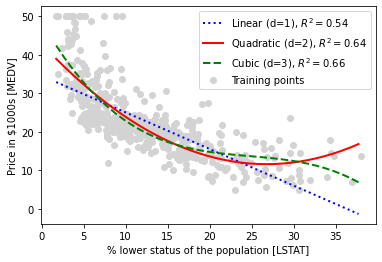

In [81]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

plt.scatter(X, y, label = 'Training points', color = 'lightgray')

plt.plot(X_fit, y_lin_fit, label = 'Linear (d=1), $R^2=%.2f$' % linear_r2, color = 'blue', lw = 2, linestyle = ':')

plt.plot(X_fit, y_quad_fit, label = 'Quadratic (d=2), $R^2=%.2f$' % quadratic_r2, color = 'red', lw = 2, linestyle = '-')

plt.plot(X_fit, y_cubic_fit, label = 'Cubic (d=3), $R^2=%.2f$' % cubic_r2, color = 'green', lw = 2, linestyle = '--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')
plt.show()

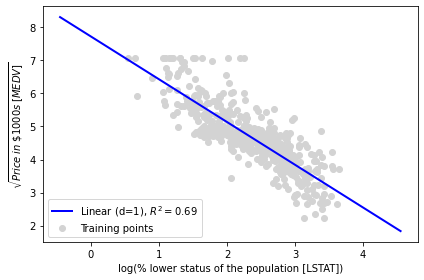

In [82]:
# log를 이용한 비선형회귀
X_log = np.log(X)
y_sqrt = np.sqrt(y)

X_fit = np.arange(X_log.min() - 1, X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)

y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

plt.scatter(X_log, y_sqrt, label = 'Training points', color = 'lightgray')
plt.plot(X_fit, y_lin_fit, label = 'Linear (d=1), $R^2=%.2f$' % linear_r2, color = 'blue', lw = 2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# tree 기반의 회귀 - Decision tree regression

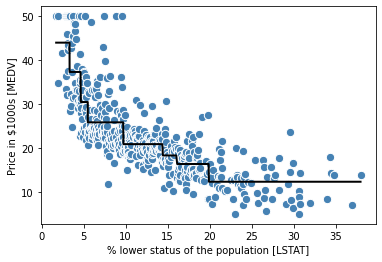

In [83]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

In [85]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

MSE train: 1.644, test: 11.085
R^2 train: 0.979, test: 0.877


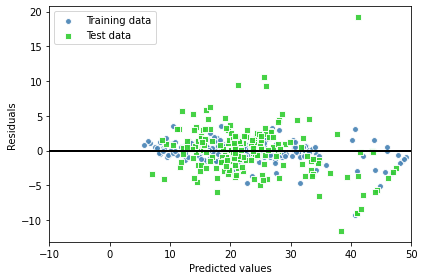

In [86]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', edgecolors='white', marker='o', s=35, alpha=0.9, label = 'Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', edgecolors='white', marker='s', s=35, alpha=0.9, label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()